In [1]:
! pip install angr
! apt install g++-arm-linux-gnueabi
! pip install torch_geometric

import angr
import networkx as nx
import torch_geometric
import torch_geometric.nn as gnn
from torch_geometric.utils.convert import from_networkx, to_networkx
from torch_geometric.loader import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

Defaulting to user installation because normal site-packages is not writeable
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Defaulting to user installation because normal site-packages is not writeable


The next cell contains the C/C++ source code for 24 mathematical functions. We compile these with various randomized compilation flags to generate our dataset.

In [2]:
c_code = """#include <stdio.h>
#include <math.h>
#include <stdlib.h>
#include <time.h>

/* This is asqrt with an additional step of the Newton iteration, for
increased accuracy.
   The relative error ranges from 0 to +0.00000023. */

float asqrt1(float x0) {
   union {int ix; float x;};

   x = x0;                      // x can be viewed as int.
   ix = 0x1fbb3f80 + (ix >> 1); // Initial guess.
   x = 0.5f*(x + x0/x);         // Newton step.
   x = 0.5f*(x + x0/x);         // Newton step again.
   return x;
}

void boundsAddu(unsigned a, unsigned b, unsigned c,
                unsigned d, unsigned *ps, unsigned *pt) {

   unsigned s, t;

// ------------------------------ cut ----------------------------------
   s = a + c;
   t = b + d;
   if (s >= a && t < b) {
      s = 0;
      t = 0xFFFFFFFF;}
// ------------------------------ cut ----------------------------------
   *ps = s;
   *pt = t;
   return;
}

/* Round up to a power of 2. */

unsigned clp2(unsigned x) {
   x = x - 1;
   x = x | (x >> 1);
   x = x | (x >> 2);
   x = x | (x >> 4);
   x = x | (x >> 8);
   x = x | (x >>16);
   return x + 1;
}

int isqrt3(unsigned x) {
   unsigned a, b, m;            // Limits and midpoint.

   a = 1;
   b = (x >> 5) + 8;            // See text.
   if (b > 65535) b = 65535;
   do {
      m = (a + b) >> 1;
      if (m*m > x) b = m - 1;
      else         a = m + 1;
   } while (b >= a);
   return a - 1;
}

// Integer log base 10, modified binary search.
int ilog10c(unsigned x) {
   if (x > 99)
      if (x < 1000000)
         if (x < 10000)
            return 3 + ((int)(x - 1000) >> 31);
         // return 3 - ((x - 1000) >> 31);              // Alternative.
         // return 2 + ((999 - x) >> 31);               // Alternative.
         // return 2 + ((x + 2147482648) >> 31);        // Alternative.
         else
            return 5 + ((int)(x - 100000) >> 31);
      else
         if (x < 100000000)
            return 7 + ((int)(x - 10000000) >> 31);
         else
            return 9 + ((int)((x-1000000000)&~x) >> 31);
         // return 8 + (((x + 1147483648) | x) >> 31);  // Alternative.
   else
      if (x > 9) return 1;
      else       return ((int)(x - 1) >> 31);
   // return ((int)(x - 1) >> 31) | ((unsigned)(9 - x) >> 31);  // Alt.
   // return (x > 9) + (x > 0) - 1;                             // Alt.
}

float rsqrt1(float x0) {
   union {int ix; float x;};

   x = x0;                      // x can be viewed as an int.
   float xhalf = 0.5f*x;
   ix = 0x5f37599e - (ix >> 1); // Initial guess.
   x = x*(1.5f - xhalf*x*x);    // Newton step.
   x = x*(1.5f - xhalf*x*x);    // Newton step again.
   return x;
}

void mulqdu1(unsigned W[], unsigned U[], unsigned V[]) {
   unsigned short *w, *u, *v;
   unsigned int k, t;
   int i, j;

   w = (unsigned short *)W;     // w, u, v reference the
   u = (unsigned short *)U;     // fullword arrays as
   v = (unsigned short *)V;     // halfwords.

   W[2] = 0;
   W[3] = 0;

   for (j = 3; j >= 0; j--) {
      k = 0;
      for (i = 3; i >= 0; i--) {
         t = u[i]*v[j] + w[i + j + 1] + k;
         w[i + j + 1] = t & 0xFFFF;
         k = t >> 16;
      }
      w[j] = k;
   }
   return;
}

// Reverses (reflects) bits in a 32-bit word.
unsigned reverse(unsigned x) {
   x = ((x & 0x55555555) <<  1) | ((x >>  1) & 0x55555555);
   x = ((x & 0x33333333) <<  2) | ((x >>  2) & 0x33333333);
   x = ((x & 0x0F0F0F0F) <<  4) | ((x >>  4) & 0x0F0F0F0F);
   x = (x << 24) | ((x & 0xFF00) << 8) |
       ((x >> 8) & 0xFF00) | (x >> 24);
   return x;
}

unsigned int crc32a(unsigned char *message) {
   int i, j;
   unsigned int byte, crc;

   i = 0;
   crc = 0xFFFFFFFF;
   while (message[i] != 0) {
      byte = message[i];            // Get next byte.
      byte = reverse(byte);         // 32-bit reversal.
      for (j = 0; j <= 7; j++) {    // Do eight times.
         if ((int)(crc ^ byte) < 0)
              crc = (crc << 1) ^ 0x04C11DB7;
         else crc = crc << 1;
         byte = byte << 1;          // Ready next msg bit.
      }
      i = i + 1;
   }
   return reverse(~crc);
}

int icbrt1(unsigned x) {
   int s;
   unsigned y, b;

   y = 0;
   for (s = 30; s >= 0; s = s - 3) {
      y = 2*y;
      b = (3*y*(y + 1) + 1) << s;
      if (x >= b) {
         x = x - b;
         y = y + 1;
      }
   }
   return y;
}

// Program for computing x**n for integers.
int iexp(int x, unsigned n) {
   int p, y;

   y = 1;                     // Initialize result
   p = x;                     // and p.
   while(1) {
      if (n & 1) y = p*y;     // If n is odd, mult by p.
      n = n >> 1;             // Position next bit of n.
      if (n == 0) return y;   // If no more bits in n.
      p = p*p;                // Power for next bit of n.
   }
}

/* Given a, b, c, and d, this program computes the max value of x & y,
where a <= x <= b and c <= y <= d (unsigned numbers).
   Max line length is 57, to fit in hacker.book. */
unsigned maxAND(unsigned a, unsigned b,
                unsigned c, unsigned d) {
   unsigned m, temp;

   m = 0x80000000;
   while (m != 0) {
      if (b & ~d & m) {
         temp = (b & ~m) | (m - 1);
         if (temp >= a) {b = temp; break;}
      }
      else if (~b & d & m) {
         temp = (d & ~m) | (m - 1);
         if (temp >= c) {d = temp; break;}
      }
      m = m >> 1;
   }
   return b & d;
}

int pop(unsigned x) {
   x = x - ((x >> 1) & 0x55555555);
   x = (x & 0x33333333) + ((x >> 2) & 0x33333333);
   x = (x + (x >> 4)) & 0x0F0F0F0F;
   x = x + (x << 8);
   x = x + (x << 16);
   return x >> 24;
}

/* Copied from GLS's note.  This is the "three shearing transformations"
method.  The code below takes 1280 ops to do the bit rearrangements
(i.e., not counting loop control, loads, stores, and indexing).  Not
competitive with the other methods.  */

#define rotateright(x, k) ((x) >> (k)) | ((x) << (32 - (k)))
#define rotateleft(x, k)  ((x) << (k)) | ((x) >> (32 - (k)))

void transpose32d(unsigned a[]) {
  int j, k, q;
  unsigned m, t, u;
  for (k = 0; k < 32; k++) a[k] = rotateright(a[k], k);
  for (j = 16, m = 0xFFFF0000; j; j >>= 1, m ^= m >> j) {
    for (k = 0; k < j; k++) {
      t = a[k] & m;
      a[k] = a[k] ^ t;
      for (q = k+j; q < 32; q += j) {
                 u = a[q] & m;
                 a[q] = a[q] ^ u ^ t;
                 t = u;
      }
      a[k] = a[k] ^ t;
    }
  }
  for (k = 0; k < 32; k++) a[k] = rotateleft(a[k], 31-k);
  for (k = 0; k < 16; k++) {
    t = a[k];
    a[k] = a[31-k];
    a[31-k] = t;
  }
}

unsigned compress(unsigned x, unsigned m) {
   unsigned mk, mp, mv, t;
   int i;

   x = x & m;           // Clear irrelevant bits.
   mk = ~m << 1;        // We will count 0's to right.

   for (i = 0; i < 5; i++) {
      mp = mk ^ (mk << 1);              // Parallel suffix.
      mp = mp ^ (mp << 2);
      mp = mp ^ (mp << 4);
      mp = mp ^ (mp << 8);
      mp = mp ^ (mp << 16);
      mv = mp & m;                      // Bits to move.
      m = m ^ mv | (mv >> (1 << i));    // Compress m.
      t = x & mv;
      x = x ^ t | (t >> (1 << i));      // Compress x.
      mk = mk & ~mp;
   }
   return x;
}

unsigned compress1(unsigned x, unsigned mask) {
  unsigned result = 0, bit = 1;
  while (mask != 0) {
    if ((mask & 1) != 0) {
      if (x & 1) result |= bit;
      bit <<= 1;
    }
    mask >>= 1;
    x >>= 1;
  }
  return result;
}

#define llabs(x) ({unsigned long long t = (x) >> 63; ((x) ^ t) - t;})

int oflo1(long long u, long long v) {

   unsigned long long au, av, del;

   if (((v << 32) >> 32) != v) return 0;
   au = llabs(u);
   av = llabs(v);
   del = ((u ^ v) >> 63) & av;
   if (au < (av << 31) + del) return 1;
   return 0;
}

int oflo2(long long u, long long v) {

   long long vs;

   if (((v << 32) >> 32) != v) return 0;
   vs = v << 31;
   if (u >= 0)
      if (v > 0) {
         if (u < vs) goto easy_case;            // +/+.
      }
      else {
         if (u + vs + v < 0) goto easy_case;    // +/-.
      }
   else
      if (v > 0) {
         if (u + vs + v > 0) goto easy_case;    // -/+.
      }
      else {
         if (u > vs) goto easy_case;            // -/-.
      }
   return 0;

easy_case:
   return 1;
}

// Version based on nonrestoring hardware algorithm:
// This more-or-less verifies the algorithm given in HD,
// but we don't include this C version because it's not very efficient.
unsigned divluh1(unsigned x, unsigned y, unsigned z) {
   // Divides (x || y) by z.
   int i;
   unsigned c;

   c = 0;
   for (i = 1; i <= 32; i++) {
      if (c == 0) {
         c = x >> 31;
         x = (x << 1) | (y >> 31); // Shift x || y left
         y = y << 1;               // one bit.
         c = c ^ (x < z);
         x = x - z;
      }
      else {
         c = x >> 31;
         x = (x << 1) | (y >> 31); // Shift x || y left
         y = y << 1;               // one bit.
         x = x + z;
         c = c ^ (x < z);
      }
      y = y + (1 - c);
   }
   return y;                    // Remainder is x.
}

unsigned divu3b(unsigned n) {
   unsigned q, r;

   q = (n >> 2) + (n >> 4);     // q = n*0.0101 (approx).
   q = q + (q >> 4);            // q = n*0.01010101.
   q = q + (q >> 8);
   q = q + (q >> 16);
   r = n - q*3;                 // 0 <= r <= 15.
   return q + (11*r >> 5);      // Returning q + r/3.
// return q + (5*(r + 1) >> 4);         // Alternative 1.
// return q + ((r + 5 + (r << 2)) >> 4);// Alternative 2.
}

#define min(x, y) ((x) < (y) ? (x) : (y))

unsigned minOR(unsigned a, unsigned b,
               unsigned c, unsigned d) {
   unsigned m, temp;

   m = 0x80000000;
   while (m != 0) {
      if (~a & c & m) {
         temp = (a | m) & -m;
         if (temp <= b) {a = temp; break;}
      }
      else if (a & ~c & m) {
         temp = (c | m) & -m;
         if (temp <= d) {c = temp; break;}
      }
      m = m >> 1;
   }
   return a | c;
}

unsigned mulhu(unsigned u, unsigned v) {
   unsigned u0, u1, v0, v1, w0, w1, w2, t;

   u0 = u & 0xFFFF;  u1 = u >> 16;
   v0 = v & 0xFFFF;  v1 = v >> 16;
   w0 = u0*v0;
   t  = u1*v0 + (w0 >> 16);
   w1 = t & 0xFFFF;
   w2 = t >> 16;
   w1 = u0*v1 + w1;
   return u1*v1 + w2 + (w1 >> 16);
}

int parity1a(unsigned x) {
   unsigned y;

   y = x ^ (x >>16);
   y = y ^ (y >> 8);
   y = y ^ (y >> 4);
   y = 0x6996 >> (y & 0xF);     // Falk Hueffner's trick.
   return y & 1;
}

// Find rightmost 0-byte, not using nlz.
int zbyter(unsigned x) {
   unsigned y;
                       // Original byte: 00 80 other
   y = (x & 0x7F7F7F7F) + 0x7F7F7F7F; // 7F 7F 1xxxxxxx
   y = ~(y | x | 0x7F7F7F7F);         // 80 00 00000000
                                      // These steps map:
   if (y == 0) return 4;              // 00000000 ==> 4,
   else if (y & 0x0000FFFF)           // xxxxxx80 ==> 0,
      return ((y >> 7) & 1) ^ 1;      // xxxx8000 ==> 1,
   else                               // xx800000 ==> 2,
      return ((y >> 23) & 1) ^ 3;     // 80000000 ==> 3.
}

int main(void) {
   return 0;
}
"""

The next two cells contain routines for generating the Control Flow Graph and Register Dependency Graph for each compiled function.

In [3]:
# Function below stolen from angr, slightly modified
def get_func_cfg(self, insn_addrs, insn_ids):
    """
    Generate a sub control flow graph of instruction addresses based on self.graph

    :param iterable ins_addrs: A collection of instruction addresses that should be included in the subgraph.
    :return networkx.DiGraph: A subgraph.
    """
    g = nx.classes.digraph.DiGraph()

    for i in range(len(insn_addrs)):
        # Add the instruction ID as an identifier for the node
        g.add_node(insn_addrs[i], x=insn_ids[i])

    # find all basic blocks that include those instructions
    blocks = []
    block_addr_to_insns = {}

    for b in self._local_blocks.values():
        # TODO: should I call get_blocks?
        block = self.get_block(b.addr, size=b.size, byte_string=b.bytestr)
        common_insns = set(block.instruction_addrs).intersection(insn_addrs)
        if common_insns:
            blocks.append(b)
            block_addr_to_insns[b.addr] = sorted(common_insns)

    # subgraph = networkx.subgraph(self.graph, blocks)
    subgraph = self.graph.subgraph(blocks).copy()

    for n in subgraph.nodes():
        insns = block_addr_to_insns[n.addr]

        in_edges = subgraph.in_edges(n)
        # out_edges = subgraph.out_edges(n)
        if len(in_edges) > 1:
            # the first instruction address should be included
            if n.addr not in insns:
                insns = [n.addr] + insns

        for src, _ in in_edges:
            last_instr = block_addr_to_insns[src.addr][-1]
            g.add_edge(last_instr, insns[0])

        for i in range(0, len(insns) - 1):
            g.add_edge(insns[i], insns[i + 1])

    return g

In [13]:
def generate_rdg(cfg, reg_reads, reg_writes):
    """ Output a register dependency graph from a cfg and dictionaries of instruction addresses
    mapping to their register reads and writes"""

    rdg = nx.DiGraph()

    embed_reg = {'r0':0,
                 'r1':1,
                 'r2':2,
                 'r3':3,
                 'r4':4,
                 'r5':5,
                 'r6':6,
                 'r7':7,
                 'r8':8,
                 'r9':9,
                 'r10':10,
                 'r11':11,
                 'r12':12,
                 'sb':13,
                 'fp':14,
                 'ip':15,
                 'sp':16,
                 'sl':17,
                 'lr':18,
                 'pc':19,
                 'cpsr':20}

    for addr, id in cfg.nodes(data="x"):
        # Add an edge from register to addr in RDG
        for reg in reg_reads[addr]:
            rdg.add_node(reg, x=embed_reg[reg])
            rdg.add_node(addr, x=len(embed_reg)+id)
            rdg.add_edge(reg, addr)

        # Add an edge from addr to register in RDG
        for reg in reg_writes[addr]:
            rdg.add_node(reg, x=embed_reg[reg])
            rdg.add_node(addr, x=len(embed_reg)+id)
            rdg.add_edge(addr, reg)

    return rdg

The next cell contains the code responsible for generating our dataset.

In [15]:
import io
from contextlib import redirect_stdout

# Generate the data for the model
train_cfg = []
train_rdg = []
original_cfg = []
original_rdg = []
assembly = []

# Get a handle on the functions we want
func_names = ['_Z6asqrt1f', '_Z10boundsAddujjjjPjS_', '_Z4clp2j', '_Z6isqrt3j',
              '_Z7ilog10cj', '_Z6rsqrt1f', '_Z7mulqdu1PjS_S_', '_Z7reversej',
              '_Z6crc32aPh', '_Z6icbrt1j', '_Z4iexpij', '_Z6maxANDjjjj',
              '_Z3popj', '_Z12transpose32dPj', '_Z8compressjj', '_Z9compress1jj',
              '_Z5oflo1xx', '_Z5oflo2xx', '_Z7divluh1jjj', '_Z6divu3bj',
              '_Z5minORjjjj', '_Z5mulhujj', '_Z8parity1aj', '_Z6zbyterj']

data_size = 0
total_size = 1000
loop = tqdm(total = len(func_names)*(total_size // len(func_names)) + len(func_names), position=0, leave=False)

# Loop to generate data
while data_size < total_size:
    # Randomize which n registers to disallow in the resulting code
    reg_perm = np.arange(16)
    np.random.shuffle(reg_perm)
    limit_num = np.random.randint(low=7, high=12)
    reg_perm = reg_perm[:limit_num]
    regs_arg = ''.join([f"-ffixed-r{reg} " for reg in reg_perm])

    # Randomize optimization level
    opt_arg = f"-O{np.random.randint(low=0, high=3)}"

    # Compile test.cpp for aarch32 with the specified compiler flags
    ! echo "{c_code}" | arm-linux-gnueabi-g++ -x c++ {regs_arg} {opt_arg} -

    # Load the executable
    project = angr.Project('a.out', load_options={'auto_load_libs': False})

    # Generate the CFG for the executable
    cfg = project.analyses.CFGFast(normalize=True)

    # Map functions to their start addresses (used for printing list of all functions)
    if verbose and data_size < len(func_names):
        func_dict = {}
        for addr, func in cfg.functions.items():
            func_dict[func.name] = addr
        print(func_dict)

    for name in func_names:
        func = cfg.functions.function(name=name)

        insn_addrs = []
        insn_ids = []
        reg_reads = dict()
        reg_writes = dict()

        # Grab the instructions, and corresponding information, to include in the graphs
        asm_code = ""
        for block in func.blocks:
            insn_addrs.extend(block.instruction_addrs)
            insn_ids.extend([insn.id for insn in block.capstone.insns])
            reg_reads.update(dict(zip([hex(addr) for addr in block.instruction_addrs],
                                      [[insn.reg_name(r) for r in insn.regs_access()[0]] for insn in block.capstone.insns])))
            reg_writes.update(dict(zip([hex(addr) for addr in block.instruction_addrs],
                                       [[insn.reg_name(r) for r in insn.regs_access()[1]] for insn in block.capstone.insns])))

            with io.StringIO() as buf, redirect_stdout(buf):
                block.pp()
                asm_code += buf.getvalue()

        # Store the raw assembly for this function (list of strings)
        assembly.append(asm_code)

        # Grab the control flow graph for this function from the cfg
        # Convert the nodes (addresses) to hexadecimal values
        func_cfg = get_func_cfg(func, insn_addrs, insn_ids)
        to_hex = {key:hex(key) for key in func_cfg.nodes()}
        func_cfg = nx.relabel_nodes(func_cfg, to_hex)

        # Generate "register read graph" and "register write graph"
        func_rdg = generate_rdg(func_cfg, reg_reads, reg_writes)

        # Convert the graphs to pytorch geometric graphs
        pyg_cfg = from_networkx(func_cfg)
        pyg_rdg = from_networkx(func_rdg)

        # Add classification labels to each
        label = func_names.index(name)
        pyg_cfg.label = label
        pyg_rdg.label = label

        original_cfg.append(func_cfg)
        original_rdg.append(func_rdg)
        train_cfg.append(pyg_cfg)
        train_rdg.append(pyg_rdg)

        data_size += 1

        loop.set_description('data_size:{}'.format(data_size))
        loop.update(1)

  0%|          | 0/1008 [00:00<?, ?it/s]

data_size:144:  14%|█▍        | 143/1008 [00:11<00:45, 18.97it/s]

<stdin>: In function ‘int oflo1(long long int, long long int)’:
<stdin>:294:1: error: unable to find a register to spill
<stdin>:294:1: error: this is the insn:
(insn 7 4 94 2 (set (reg:DI 160 [128])
        (mem/c:DI (plus:SI (reg/f:SI 102 sfp)
                (const_int -60 [0xffffffffffffffc4])) [10 v+0 S8 A64])) "<stdin>":288:12 251 {*arm_movdi}
     (nil))
<stdin>:294: confused by earlier errors, bailing out


data_size:192:  19%|█▉        | 192/1008 [00:15<00:45, 17.74it/s]

<stdin>: In function ‘int oflo1(long long int, long long int)’:
<stdin>:294:1: error: unable to find a register to spill
<stdin>:294:1: error: this is the insn:
(insn 7 4 94 2 (set (reg:DI 160 [128])
        (mem/c:DI (plus:SI (reg/f:SI 102 sfp)
                (const_int -60 [0xffffffffffffffc4])) [11 v+0 S8 A64])) "<stdin>":288:12 251 {*arm_movdi}
     (nil))
<stdin>:294: confused by earlier errors, bailing out


data_size:264:  26%|██▌       | 263/1008 [00:19<00:31, 23.46it/s]

<stdin>: In function ‘int oflo1(long long int, long long int)’:
<stdin>:294:1: error: unable to find a register to spill
<stdin>:294:1: error: this is the insn:
(insn 7 4 94 2 (set (reg:DI 160 [128])
        (mem/c:DI (plus:SI (reg/f:SI 102 sfp)
                (const_int -60 [0xffffffffffffffc4])) [10 v+0 S8 A64])) "<stdin>":288:12 251 {*arm_movdi}
     (nil))
<stdin>:294: confused by earlier errors, bailing out


data_size:384:  38%|███▊      | 383/1008 [00:27<00:28, 22.07it/s]

<stdin>: In function ‘int oflo1(long long int, long long int)’:
<stdin>:294:1: error: unable to find a register to spill
<stdin>:294:1: error: this is the insn:
(insn 7 4 94 2 (set (reg:DI 160 [128])
        (mem/c:DI (plus:SI (reg/f:SI 102 sfp)
                (const_int -60 [0xffffffffffffffc4])) [10 v+0 S8 A64])) "<stdin>":288:12 251 {*arm_movdi}
     (nil))
<stdin>:294: confused by earlier errors, bailing out


data_size:744:  74%|███████▎  | 743/1008 [00:54<00:15, 17.35it/s]

<stdin>: In function ‘int oflo1(long long int, long long int)’:
<stdin>:294:1: error: unable to find a register to spill
<stdin>:294:1: error: this is the insn:
(insn 7 4 94 2 (set (reg:DI 160 [128])
        (mem/c:DI (plus:SI (reg/f:SI 102 sfp)
                (const_int -60 [0xffffffffffffffc4])) [10 v+0 S8 A64])) "<stdin>":288:12 251 {*arm_movdi}
     (nil))
<stdin>:294: confused by earlier errors, bailing out


data_size:1008: 100%|█████████▉| 1007/1008 [01:12<00:00, 21.68it/s]

data_size:1008: 100%|██████████| 1008/1008 [01:23<00:00, 21.68it/s]

The following code implements our deep neural network. We first pass in the CDG and the RDG through two separate graph convolutional networks (with GATv2Conv layers).

We then concatenate the results and pass them through a linear layer to produce the classification scores.

batch:8999 loss:0.0718 val_accuracy:0.9100: 100%|█████████▉| 8999/9000 [09:43<00:00, 16.34it/s]

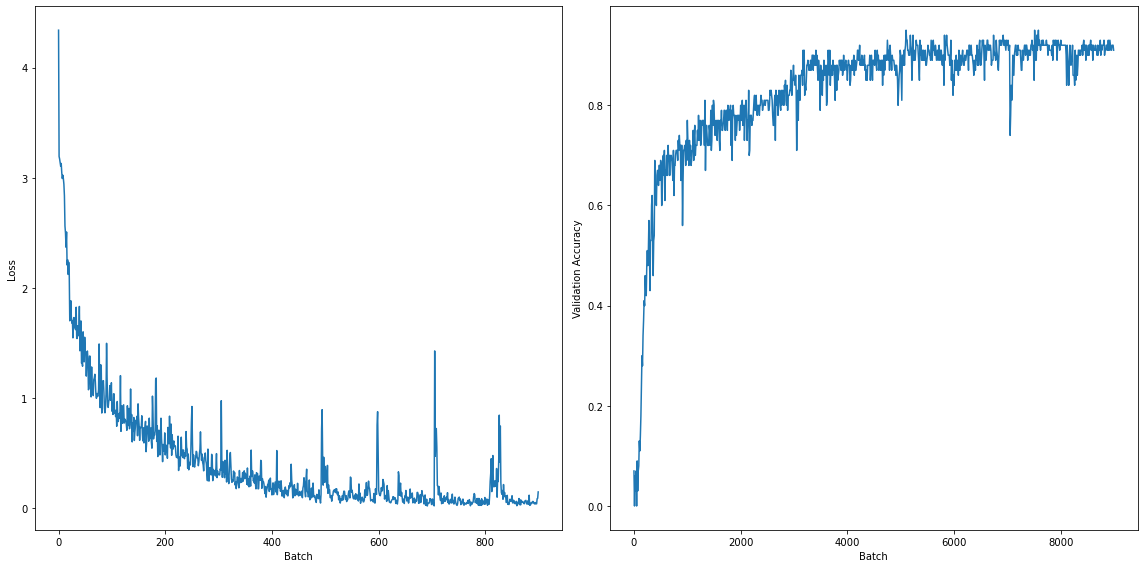

batch:8999 loss:0.0718 val_accuracy:0.9100: 100%|██████████| 9000/9000 [10:00<00:00, 16.34it/s]

In [114]:
num_classes = len(func_names)

# Graph convolutional network
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()

        self.layer1 = gnn.Sequential('x, edge_index', [
            (gnn.GATv2Conv(1, 16), 'x, edge_index -> x'),
            nn.ReLU(inplace=True),
            (gnn.GATv2Conv(16, 32), 'x, edge_index -> x'),
            nn.ReLU(inplace=True),
            (gnn.GATv2Conv(32, 32), 'x, edge_index -> x'),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
        ])

        self.layer2 = gnn.Sequential('x, edge_index', [
            (gnn.GATv2Conv(1, 16), 'x, edge_index -> x'),
            nn.ReLU(inplace=True),
            (gnn.GATv2Conv(16, 32), 'x, edge_index -> x'),
            nn.ReLU(inplace=True),
            (gnn.GATv2Conv(32, 32), 'x, edge_index -> x'),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
        ])

        self.reshape = nn.Sequential(
            nn.Linear(16*2, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes),
        )

    def forward(self, data1, data2):
        # Pass the CFG and the RDG through the Sequential layer (so we have serparate weights)
        x1, edge_index1, batch1 = data1.x.reshape(-1,1).float(), data1.edge_index, data1.batch
        x2, edge_index2, batch2 = data2.x.reshape(-1,1).float(), data2.edge_index, data2.batch
        x1 = self.layer1(x1, edge_index1)
        x2 = self.layer2(x2, edge_index2)

        # Pool the batch together so we learn to classify the graph (rather than nodes)
        x1 = gnn.global_mean_pool(x1, batch1)
        x2 = gnn.global_mean_pool(x2, batch2)

        # Concatenate the outputs of layer1 and layer2 and pass through a linear layer
        # The output of this layer is our classification scheme.
        out = torch.cat((x1,x2), dim=1)
        out = self.reshape(out)

        return out

# Initialize DataLoaders with a 90-10 spread for training/validation datasets
combined_data = list(zip(train_cfg, train_rdg))
indices = list(range(len(combined_data)))
np.random.shuffle(indices)

batch_size = 100
val_batch_size = int(0.1*len(combined_data))

# Drop last batch so we don't get random spikes in the loss/accuracy plots
train_loader = DataLoader([combined_data[i] for i in indices[int(0.1*len(combined_data)):]],
                          batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader([combined_data[i] for i in indices[:int(0.1*len(combined_data))]],
                        batch_size=int(0.1*len(combined_data)))

# Initialize models
model = GCN()

# Initialize objective and optimizers and other parameters
optim1 = optim.Adam(model.parameters(), lr=2e-3)
objective = nn.CrossEntropyLoss()

# Initialize lists for plotting
losses = []
val_accuracy = []

num_epochs = 1000
loop = tqdm(total=num_epochs*len(train_loader), position=0, leave=False)
batches = 0

for epoch in range(num_epochs):
    for data in train_loader:
        optim1.zero_grad()
        # Pass the graphs through the GCN
        y_hat1 = model(*data)

        # Compute CrossEntropyLoss
        target = data[0].label
        loss = objective(y_hat1, target)

        # Stochastic gradient descent step
        loss.backward()
        optim1.step()

        # Store loss and accuracy every 10 batches
        if batches % 10 == 0:
            losses.append(loss.item())
            for data in val_loader:
                #print(data[0].label.shape)
                with torch.no_grad():
                    # Pass the graphs through the GCN
                    y_hat1 = model(*data)

                # See what proportion of the time the model predicted the correct classification
                # for data in the validation loader
                target = data[0].label
                acc = torch.sum(torch.argmax(y_hat1, dim=1) == target)/val_batch_size
                val_accuracy.append(acc)

        loop.set_description('batch:{} loss:{:.4f} val_accuracy:{:.4f}'.format(batches, loss.item(), acc))
        loop.update(1)
        batches += 1

# Plot the resulting loss and validation accuracy
plt.gcf().set_size_inches(16, 8)

plt.subplot(1,2,1)
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Batch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(10*np.arange(len(val_accuracy)), val_accuracy)
plt.xlabel("Batch")
plt.ylabel("Validation Accuracy")

plt.tight_layout()
plt.show()

Actual Function: _Z8compressjj
 Predicted              |   Probability
------------------------+---------------
 _Z8compressjj          |   0.904234
 _Z6maxANDjjjj          |   0.0957662
 _Z5oflo1xx             |   5.03481e-10
 _Z10boundsAddujjjjPjS_ |   1.81112e-11
 _Z8parity1aj           |   3.47113e-14



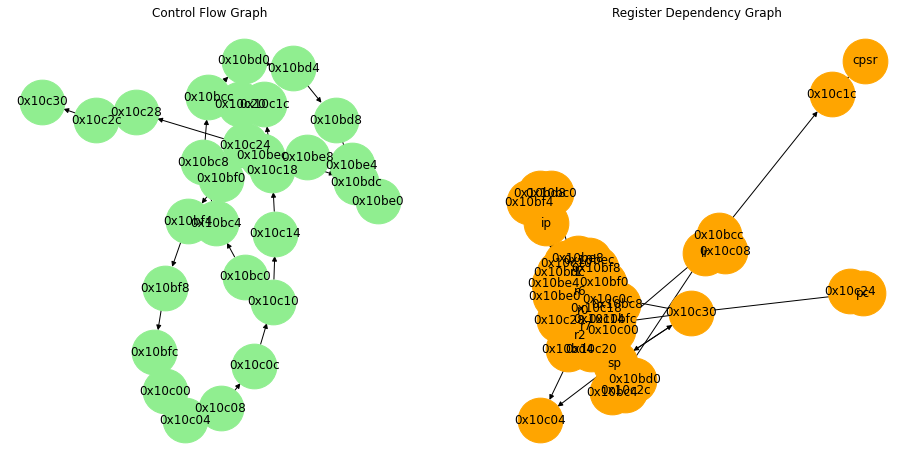

       _Z8compressjj:
10bc0  mvn     ip, r1
10bc4  push    {r6, r7, lr}
10bc8  mov     r2, r1
10bcc  mov     lr, #init
10bd0  sub     sp, sp, #0xc
10bd4  and     r7, r0, r1
10bd8  lsl     ip, ip, #0x1
10bdc  eor     r6, ip, ip, lsl#1
10be0  eor     r6, r6, r6, lsl#2
10be4  eor     r6, r6, r6, lsl#4
10be8  eor     r6, r6, r6, lsl#8
10bec  eor     r6, r6, r6, lsl#16
10bf0  and     r0, r6, r2
10bf4  bic     ip, ip, r6
10bf8  bic     r6, r2, r6
10bfc  mov     r2, #0x1
10c00  lsl     r2, r2, lr
10c04  str     r2, [sp,#0x4]
10c08  add     lr, lr, #0x1
10c0c  orr     r2, r6, r0, lsrr2
10c10  and     r6, r0, r7
10c14  bic     r0, r7, r0
10c18  ldr     r7, [sp,#0x4]
10c1c  cmp     lr, #0x5
10c20  orr     r7, r0, r6, lsrr7
10c24  bne     #0x10bdc
10c28  mov     r0, r7
10c2c  add     sp, sp, #0xc
10c30  pop     {r6, r7, pc}



In [116]:
from tabulate import tabulate

def sample_dataset(assembly, original_cfg, original_rdg, index=None):
    if index is None:
        index = np.random.choice(len(assembly))

    func_cfg = original_cfg[index]
    func_rdg = original_rdg[index]

    plt.gcf().set_size_inches(16, 8)
    plt.subplot(121)
    nx.draw(func_cfg, with_labels=True, node_color='lightgreen', node_size=2000, font_size=12, font_color='black', pos=nx.fruchterman_reingold_layout(func_cfg))
    plt.gca().set_title("Control Flow Graph")

    plt.subplot(122)
    nx.draw(func_rdg, with_labels=True, node_color='orange', node_size=2000, font_size=12, font_color='black', pos=nx.fruchterman_reingold_layout(func_rdg))
    plt.gca().set_title("Register Dependency Graph")
    plt.show()

    print(assembly[index])

def sample_validation_top5(model, val_loader, eff_indices, assembly, original_cfg, original_rdg):
    for batch in val_loader:
        n = len(batch[0].label)
        idx = np.random.choice(n)

        chosen_fun = batch[0].label[idx]
        y_truth = func_names[chosen_fun]

        y_hat = model(*batch)[idx,:]
        y_hat = F.softmax(y_hat, dim=0)
        predictions = torch.topk(y_hat, 5, sorted=True)
        print(f"Actual Function: {y_truth}")

        table = []
        for pred in predictions.indices:
            table.append([func_names[pred.item()], y_hat[pred]])

        print(tabulate(table, headers=['Predicted', 'Probability'], tablefmt='presto'))
        print()

        real_idx = eff_indices[idx]
        sample_dataset(assembly, original_cfg, original_rdg, real_idx)

eff_indices = indices[:int(0.1*len(combined_data))]
sample_validation_top5(model, val_loader, eff_indices, assembly, original_cfg, original_rdg)

Actual Function: _Z6icbrt2j
 Predicted        |   Probability
------------------+---------------
 _Z6icbrt1j       |   0.494459
 _Z7mulqdu1PjS_S_ |   0.438626
 _Z6divu3bj       |   0.0433024
 _Z5oflo2xx       |   0.023218
 _Z7divluh1jjj    |   0.000388379



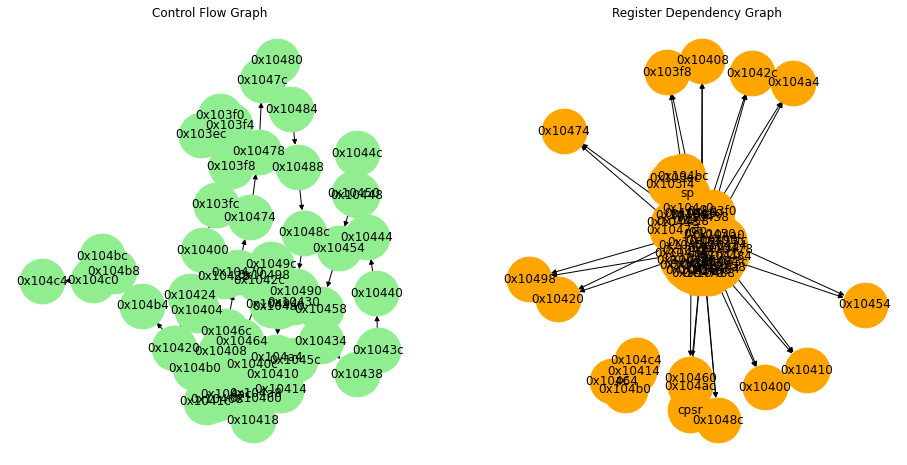

       _Z6icbrt2j:
103ec  str     fp, [sp,#-0x4]!
103f0  add     fp, sp, #init
103f4  sub     sp, sp, #0x1c
103f8  str     r0, [fp,#-0x18]
103fc  mov     r1, #init
10400  str     r1, [fp,#-0xc]
10404  mov     r1, #init
10408  str     r1, [fp,#-0x10]
1040c  mov     r1, #0x1e
10410  str     r1, [fp,#-0x14]
10414  b       #0x104a8
104a8  ldr     r1, [fp,#-0x14]
104ac  cmp     r1, #init
104b0  bge     #0x10418
10418  ldr     r1, [fp,#-0xc]
1041c  lsl     r1, r1, #0x2
10420  str     r1, [fp,#-0xc]
10424  ldr     r1, [fp,#-0x10]
10428  lsl     r1, r1, #0x1
1042c  str     r1, [fp,#-0x10]
10430  ldr     r0, [fp,#-0xc]
10434  ldr     r1, [fp,#-0x10]
10438  add     r0, r0, r1
1043c  mov     r1, r0
10440  lsl     r1, r1, #0x1
10444  add     r1, r1, r0
10448  add     r0, r1, #0x1
1044c  ldr     r1, [fp,#-0x14]
10450  lsl     r1, r0, r1
10454  str     r1, [fp,#-0x8]
10458  ldr     r0, [fp,#-0x18]
1045c  ldr     r1, [fp,#-0x8]
10460  cmp     r0, r1
10464  blo     #0x1049c
104b4  ldr     r1, [fp,#-0x

In [123]:
# Testing to make sure the model is sane
import io
from contextlib import redirect_stdout

# We trained on icbrt1 but not on icbrt2
test_code = """
int icbrt2(unsigned x) {
   int s;
   unsigned y, b, y2;

   y2 = 0;
   y = 0;
   for (s = 30; s >= 0; s = s - 3) {
      y2 = 4*y2;
      y = 2*y;
      b = (3*(y2 + y) + 1) << s;
      if (x >= b) {
         x = x - b;
         y2 = y2 + 2*y + 1;
         y = y + 1;
      }
   }
   return y;
}

int main() {
   return 0;
}
"""

# Get a handle on the functions we want
func_name = '_Z6icbrt2j'

# Randomize which n registers to disallow in the resulting code
reg_perm = np.arange(16)
np.random.shuffle(reg_perm)
limit_num = np.random.randint(low=7, high=12)
reg_perm = reg_perm[:limit_num]
regs_arg = ''.join([f"-ffixed-r{reg} " for reg in reg_perm])

# Randomize optimization level
opt_arg = f"-O{np.random.randint(low=0, high=3)}"

# Compile test.cpp for aarch32 with the specified compiler flags
! echo "{test_code}" | arm-linux-gnueabi-g++ -x c++ {regs_arg} {opt_arg} -

# Load the executable
project = angr.Project('a.out', load_options={'auto_load_libs': False})

# Generate the CFG for the executable
cfg = project.analyses.CFGFast(normalize=True)
func = cfg.functions.function(name=func_name)

insn_addrs = []
insn_ids = []
reg_reads = dict()
reg_writes = dict()

# Grab the instructions, and corresponding information, to include in the graphs
asm_code = ""
for block in func.blocks:
    insn_addrs.extend(block.instruction_addrs)
    insn_ids.extend([insn.id for insn in block.capstone.insns])
    reg_reads.update(dict(zip([hex(addr) for addr in block.instruction_addrs],
                                [[insn.reg_name(r) for r in insn.regs_access()[0]] for insn in block.capstone.insns])))
    reg_writes.update(dict(zip([hex(addr) for addr in block.instruction_addrs],
                                [[insn.reg_name(r) for r in insn.regs_access()[1]] for insn in block.capstone.insns])))

    with io.StringIO() as buf, redirect_stdout(buf):
        block.pp()
        # Store the raw assembly for this function (list of strings)
        asm_code += buf.getvalue()

# Grab the control flow graph for this function from the cfg
# Convert the nodes (addresses) to hexadecimal values
func_cfg = get_func_cfg(func, insn_addrs, insn_ids)
to_hex = {key:hex(key) for key in func_cfg.nodes()}
func_cfg = nx.relabel_nodes(func_cfg, to_hex)

# Generate "register read graph" and "register write graph"
func_rdg = generate_rdg(func_cfg, reg_reads, reg_writes)

# Convert the graphs to pytorch geometric graphs
pyg_cfg = from_networkx(func_cfg)
pyg_rdg = from_networkx(func_rdg)

# Add classification labels to each
pyg_cfg.label = label
pyg_rdg.label = label

y_hat = model(pyg_cfg, pyg_rdg)
y_hat = F.softmax(y_hat, dim=1)[0]
predictions = torch.topk(y_hat, 5, sorted=True)
print(f"Actual Function: {func_name}")

# Get a handle on the functions we want
func_names = ['_Z6asqrt1f', '_Z10boundsAddujjjjPjS_', '_Z4clp2j', '_Z6isqrt3j',
              '_Z7ilog10cj', '_Z6rsqrt1f', '_Z7mulqdu1PjS_S_', '_Z7reversej',
              '_Z6crc32aPh', '_Z6icbrt1j', '_Z4iexpij', '_Z6maxANDjjjj',
              '_Z3popj', '_Z12transpose32dPj', '_Z8compressjj', '_Z9compress1jj',
              '_Z5oflo1xx', '_Z5oflo2xx', '_Z7divluh1jjj', '_Z6divu3bj',
              '_Z5minORjjjj', '_Z5mulhujj', '_Z8parity1aj', '_Z6zbyterj']

table = []
for pred in predictions.indices:
   table.append([func_names[pred.item()], y_hat[pred]])

print(tabulate(table, headers=['Predicted', 'Probability'], tablefmt='presto'))
print()

plt.gcf().set_size_inches(16, 8)
plt.subplot(121)
nx.draw(func_cfg, with_labels=True, node_color='lightgreen', node_size=2000, font_size=12, font_color='black', pos=nx.fruchterman_reingold_layout(func_cfg))
plt.gca().set_title("Control Flow Graph")

plt.subplot(122)
nx.draw(func_rdg, with_labels=True, node_color='orange', node_size=2000, font_size=12, font_color='black', pos=nx.fruchterman_reingold_layout(func_rdg))
plt.gca().set_title("Register Dependency Graph")
plt.show()

print(asm_code)
